<img src="./fiuba.jpg" align="right" width="150" /> 
#### Procesamiento Digital de Señales

# Trabajo Práctico 1
#### Nombre y Apellido
#### Christian Yanez
***
## Procesos - Aleatorios

<div class="alert alert-block alert-info">
<b>Recepción de una señal degradada</b> 
    
    Un receptor de comunicaciónes posee un frontend analógico que recibe señalas moduladas en PAM (Pulse Amplitude Modulation), por medio de pulsos de forma exponencial.
    El canal por el cual viajan estos pulsos es un canal AWGN (Additive White Gaussian Noise), por lo cual la señal recibida se verá degradada notablemente. En principio, se puede suponer que afecta de forma independiente a cada muestra de la señal.
    Se dispone de una trama digitalizada muestreada a 20 samples/pulso. La trama contiene un header de 16 bytes donde cada byte es: 10101100. La modulación empleada es antipodal.
    
            Pulso positivo -> bit 1
            Pulso negativo -> bit 0

</div>

<div class="alert alert-block alert-info">
<b>Notas:</b> 
    
    La señal se encuentra sincronizada a nivel muestra. Por esta razón, la muestra 0 corresponde al comienzo de un pulso exponencial.
    
    Tener en cuenta que el objetivo es recuperar la información, lo cual no implica recuperar fielmente la señal enviada. Esto es clásico  en problemas de comunicaciones: sabemos la forma de la modulación (la forma de los pulsos y como se modulan), lo que no sabemos es con qué valores fueron modulados.

</div>

<div class="alert alert-block alert-info">
<b>Objetivos principales:</b> 
    
    * Detectar la secuencia de bits recibida de forma confiable 
    * Investigar diferentes métodos de demodulación
    
    Para ello se pide:

</div>

<div class="alert alert-block alert-info">
<b>Parte 1</b> 
    
    a) Filtrar la señal con un filtro digital para eliminar potencia de ruido. Pueden probar con filtros FIR o IIR, los que les parezcan convenientes.
    ¿Es óptimo el filtro elegido para detectar la información en forma confiable?
    
    b) Definir un umbral que permita tomar decisiones ("vino un 1" o "vino un 0") para cada pulso y reconstruir la trama enviada. Nuevamente, ¿Es óptimo ese umbral?

</div>

<div class="alert alert-block alert-info">
<b></b> Señal de entrada

</div>

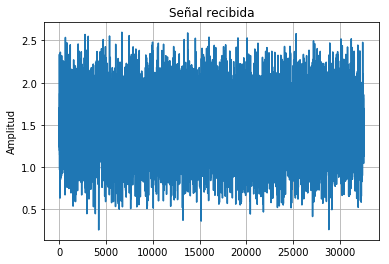

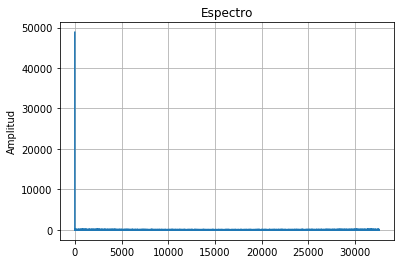

In [14]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.fftpack as sc

data = np.load('signalLowSNR.npy')
#signal.npy
#signalLowSNR.npy


espectro=sc.fft(data)
modulo_espectro=np.abs(espectro)

plt.figure(1)
plt . plot (data)
plt.title('Señal recibida')
plt.ylabel('Amplitud')
plt.grid(which='both', axis='both')

plt.figure(2)
plt . plot (modulo_espectro)
plt.title('Espectro')
plt.ylabel('Amplitud')
plt.grid(which='both', axis='both')
plt.show()


<div class="alert alert-block alert-info">
<b></b> Pulso exponencial

</div>

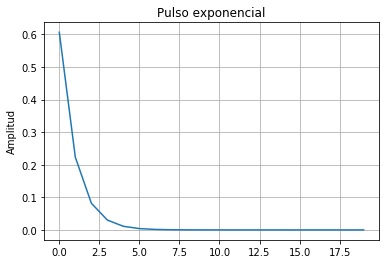

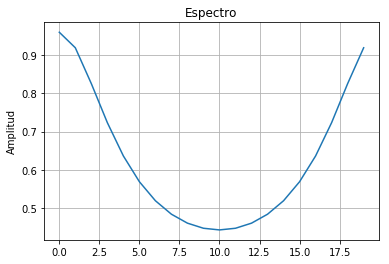

In [19]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.fftpack as sc

dat = np.load('pulse.npy')
spectro=sc.fft(dat)
m_spectro=np.abs(spectro)

plt.figure(1)
plt . plot (dat)
plt.title('Pulso exponencial')
plt.ylabel('Amplitud')
plt.grid(which='both', axis='both')

plt.figure(2)
plt . plot ((m_spectro))
plt.title('Espectro')
plt.ylabel('Amplitud')
plt.grid(which='both', axis='both')
plt.show()

<div class="alert alert-block alert-warning">
<b>Criterio 1:</b> De lo anterior se desprende que tanto el pulso como la señal resultante de la transmisión tienen concentrado su espectro en bajas frecuencias, haciendo muy complicado diferenciar ambos mediante las técnicas de filtrado hasta ahora vistas.
    A continuación se muestra el resultado de aplicar un filtro pasabajos. 
</div>

<div class="alert alert-block alert-info">
<b>Filtro pasabajos</b> 

</div>

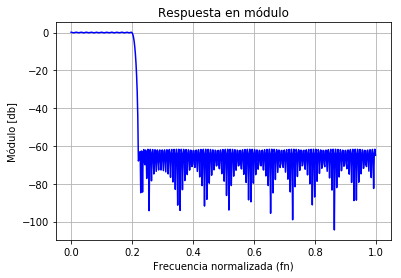

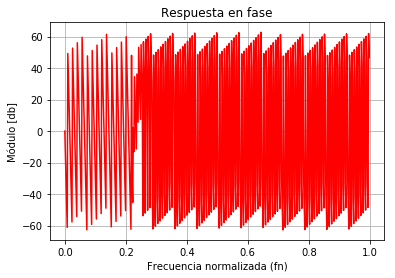

In [21]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal as sp

parametros_filtro = np.load('uno.npz')

H= parametros_filtro['ba']
b = H[0]
a = H[1]

w, h = sp.freqz(b, 1)
w=w/np.pi

plt.figure(1)
plt . plot ( w ,  20  *  np . log10 ( abs ( h )),  'b' ) 
plt.title('Respuesta en módulo')
plt.xlabel("Frecuencia normalizada (fn)")
plt.ylabel("Módulo [db]")
plt.grid(which='both', axis='both')
plt.show()

plt.figure(2)
#Respuesta en fase 
plt.plot(w, 20 * np.angle(h),'r', label='fase')
plt.title('Respuesta en fase')
plt.xlabel("Frecuencia normalizada (fn)")
plt.ylabel("Módulo [db]")
plt.grid(which='both', axis='both')
plt.show()

<div class="alert alert-block alert-info">
<b></b> Respuesta de filtrado para los primeros 8 bytes

</div>

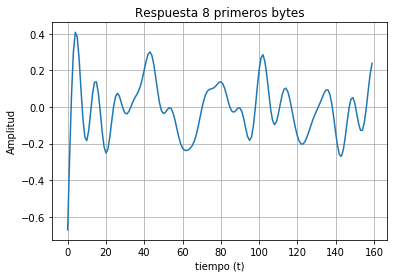

In [40]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal as sp


data = np.load('signalLowSNR.npy')
#signal.npy
#signalLowSNR.npy

parametros_filtro = np.load('uno.npz')#retardo de grupo = 124.5

H= parametros_filtro['ba']
b = H[0]
a = H[1]


salida=sp.lfilter(b,a,data)
#----------------------------------------------------
#Para eliminar la componente de continua se calcula la media
#y luego se resta la misma a los datos.

salida_med=np.mean(salida)
salida2=salida-salida_med

#Se dibuja los primeros  8 bytes luego de eliminar el 
#retardo propio de aplicar el filtro
plt . plot (salida2[124:284])
plt.title('Respuesta 8 primeros bytes')
plt.xlabel("tiempo (t)")
plt.ylabel("Amplitud")
plt.grid(which='both', axis='both')

plt.show()

<div class="alert alert-block alert-info">
<b>Recuperación de datos</b> 

</div>

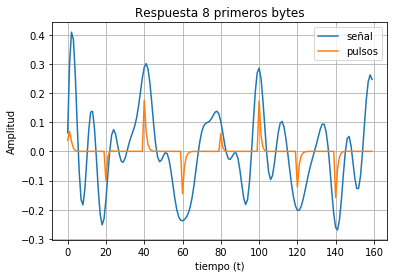

In [45]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal as sp


data = np.load('signalLowSNR.npy')
pulso = np.load('pulse.npy')

parametros_filtro = np.load('uno.npz')#retardo de grupo = 124.5

H= parametros_filtro['ba']
b = H[0]
a = H[1]

salida=sp.lfilter(b,a,data)
#----------------------------------------------------
#Para eliminar la componente de continua

salida_med=np.mean(salida)
salida2=salida-salida_med

estimado=[]
#Se extrae el primer header considerando el retardo de la etapa de filtrado
byt=salida2[126:286]# headers: (126:286) (286:446)  (446:606)  (606:766)  (766:926)  (926:1086) 

#Se multiplica el byte del header por el pulso de modulación
#con esto se logra conservar la caracteristica exponencial 
#en los primeros datos de la muestra de 20 samples.

for i in range(8):
    ventana=byt[(i*20):(i*20)+20]
    res=ventana*pulso
    estimado[i*20:(i*20)+20]=res

#Se dibujan los primeros  8 bytes luego de eliminar el 
#retardo propio de aplicar el filtro
plt . plot (byt)
plt . plot (estimado)
plt.title('Respuesta para el primer header')
plt.legend(('señal','pulsos'),loc="upper right")  
plt.xlabel("tiempo (t)")
plt.ylabel("Amplitud")
plt.grid(which='both', axis='both')

plt.show()

<div class="alert alert-block alert-warning">
<b>Conclusión 1:</b> De lo anterior se puede apreciar que los pulsos resultantes establecen la secuencia esperada (10101100) considerando la exponencial decreciente como bit=1 y la exponencial creciente como bit=0.
    
    Puede notarse también que en algunos bytes la exponencial tiene una amplitud muy baja por lo que no se puede seleccionar un nivel mínimo de referencia.
</div>

<div class="alert alert-block alert-info">
<b></b> Recuperación de datos para todo el header

</div>

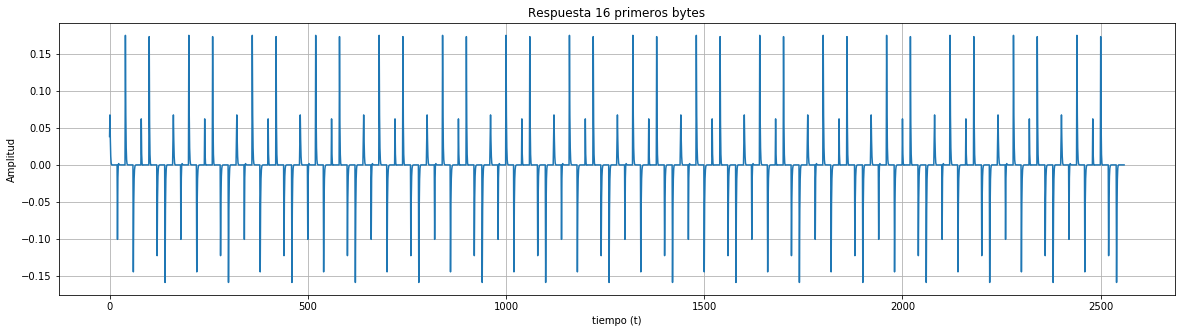

In [51]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal as sp
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (20,5)

data = np.load('signalLowSNR.npy')
pulso = np.load('pulse.npy')

parametros_filtro = np.load('uno.npz')#retardo de grupo = 124.5

H= parametros_filtro['ba']
b = H[0]
a = H[1]

salida=sp.lfilter(b,a,data)
#----------------------------------------------------
#Para eliminar la componente de continua

salida_med=np.mean(salida)
salida2=salida-salida_med

estimado=[]
header_bin=[]

#Selección de todo el encabezado
byt=salida2[126:2686] 
#Estimación de bits para todo el encabezado    
for j in range(16):
    header=byt[(j*160):(j*160)+160]   
    for i in range(8):
        header=byt[(i*20):(i*20)+20]
        res=header*pulso
        estimado[i*20:(i*20)+20]=res
    header_bin[(j*160):(j*160)+160]=estimado

plt . plot (header_bin)
plt.title('Respuesta 16 primeros bytes')
plt.xlabel("tiempo (t)")
plt.ylabel("Amplitud")
plt.grid(which='both', axis='both')

plt.show()

<div class="alert alert-block alert-warning">
<b>Conclusión 2:</b> De lo anterior se puede apreciar que los pulsos resultantes establecen la secuencia esperada (10101100) para los 16 bytes del encabezado.
    
    Se concluye que el método utilizado garantiza alto porcentaje de acierto en la recuperación o estimación de datos recibidos.
</div>

<div class="alert alert-block alert-info">
<b>Digitalización</b> 

</div>

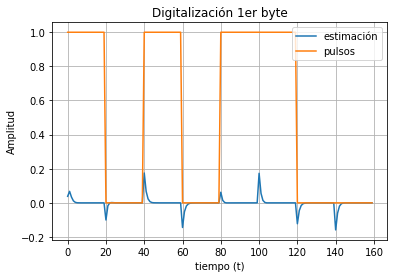

In [60]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal as sp
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (6,4)

data = np.load('signalLowSNR.npy')
pulso = np.load('pulse.npy')

parametros_filtro = np.load('uno.npz')#retardo de grupo = 124.5

H= parametros_filtro['ba']
b = H[0]
a = H[1]

salida=sp.lfilter(b,a,data)
#----------------------------------------------------
#Para eliminar la componente de continua

salida_med=np.mean(salida)
salida2=salida-salida_med

estimado=[]
estimado_bin=[]
#Se extrae el primer header considerando el retardo de la etapa de filtrado
byt=salida2[126:286]

for i in range(8):
    ventana=byt[(i*20):(i*20)+20]
    res=ventana*pulso
    estimado[i*20:(i*20)+20]=res
    positivo=abs(max(res))
    negativo=abs(min(res))
    if positivo>negativo:
        aux=np.ones(20)
        estimado_bin[i*20:(i*20)+20]=aux
    else:
        aux2=np.zeros(20)
        estimado_bin[i*20:(i*20)+20]=aux2

plt . plot (estimado)
plt . plot (estimado_bin)
plt.title('Digitalización 1er byte')
plt.legend(('estimación','pulsos'),loc="upper right")  
plt.xlabel("tiempo (t)")
plt.ylabel("Amplitud")
plt.grid(which='both', axis='both')

plt.show()

<div class="alert alert-block alert-info">
<b></b>Digitalización del header completo

</div>

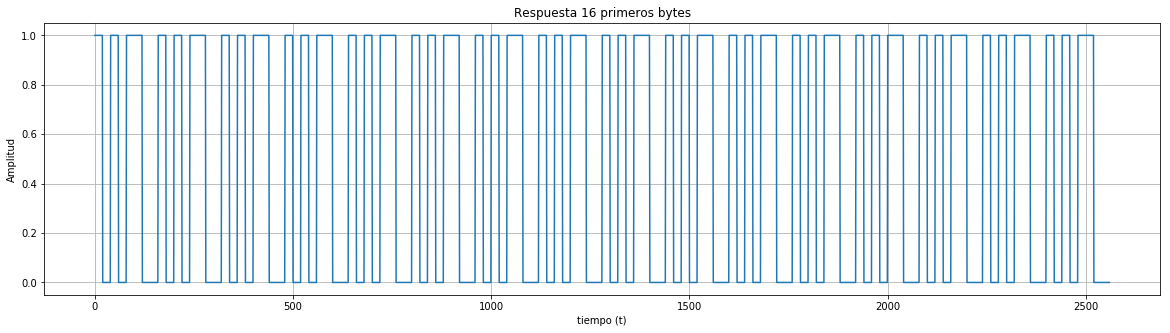

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal as sp
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (20,5)

data = np.load('signalLowSNR.npy')
pulso = np.load('pulse.npy')

parametros_filtro = np.load('uno.npz')#retardo de grupo = 124.5

H= parametros_filtro['ba']
b = H[0]
a = H[1]

salida=sp.lfilter(b,a,data)
#----------------------------------------------------
#Para eliminar la componente de continua

salida_med=np.mean(salida)
salida2=salida-salida_med

estimado=[]
estimado_bin=[]
header_bin=[]

#Selección de todo el encabezado
byt=salida2[126:2686] 
#Estimación de bits para todo el encabezado    
for j in range(16):
    header=byt[(j*160):(j*160)+160]   
    for i in range(8):
        header=byt[(i*20):(i*20)+20]
        res=header*pulso
        estimado[i*20:(i*20)+20]=res
        positivo=abs(max(res))
        negativo=abs(min(res))
        if positivo>negativo:
            aux=np.ones(20)
            estimado_bin[i*20:(i*20)+20]=aux
        else:
            aux2=np.zeros(20)
            estimado_bin[i*20:(i*20)+20]=aux2

    header_bin[(j*160):(j*160)+160]=estimado_bin

plt . plot (header_bin)
plt.title('Respuesta 16 primeros bytes')
plt.xlabel("tiempo (t)")
plt.ylabel("Amplitud")
plt.grid(which='both', axis='both')

plt.show()

<div class="alert alert-block alert-warning">
<b>Conclusión Final:</b> De lo anterior se puede apreciar que los pulsos resultantes establecen la secuencia esperada (10101100) para los 16 bytes del encabezado.
    
</div>

<div class="alert alert-block alert-warning">
<b>Resumen:</b> Para la recuperación de los datos se realiza un filtrado de primera etapa (mediante un filtro FIR pasabajos). En segundo lugar, se aplica una multiplicación de cada bit (20 samples) por la función pulso exponencial, con esto se logra recuperar la caracteristica exponencial decreciente o creciente de los bits enviados 1 o 0 respectivamente. Finalmente, al tener la caracteristica exponencial de cada bit (20 samples) se analizan los puntos maximos y minimos (en valor absoluto) para determinar la salida 1 o 0 respectiva de la señal recuperada.
    
</div>